# Statsbomb Pitch Plotting

---

## Import

In [3]:
import os
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from utils.FCPython import createPitch
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.linear_model import LinearRegression
import matplotlib.patches as plt_patches
import matplotlib.patheffects as plt_eff
from sklearn.linear_model import LogisticRegression
import seaborn as sns
import matplotlib.patches as plt_patches
from scipy.spatial import ConvexHull
from scipy import stats

In [2]:
STATSBOMB_BASE_PATH = "../../open-data/data"

STATSBOMB_COMPETITIONS_PATH = f"{STATSBOMB_BASE_PATH}/competitions.json"
STATSBOMB_MATCHES_PATH = f"{STATSBOMB_BASE_PATH}/matches"
STATSBOMB_EVENTS_PATH = f"{STATSBOMB_BASE_PATH}/events"

---

## Competitions & Number of Matches

In [3]:
with open(STATSBOMB_COMPETITIONS_PATH) as f:
    competitions = json.load(f)

**Every element of the list is a different competition. We'll need the competition_id and the season_id to load the corresponding matches.**

**Let's plot every combination of comp_id & seas_id ordered by number of matches**

In [4]:
competitions = {key: list() for key in ["competition", "season", "comp_id", "seas_id", "matches"]}

for comp in os.listdir(STATSBOMB_MATCHES_PATH):
    for season in os.listdir(f"{STATSBOMB_MATCHES_PATH}/{comp}"):
        with open(f"{STATSBOMB_MATCHES_PATH}/{comp}/{season}", "r", encoding = "utf-8") as f:
            tmp = json.load(f)
        if tmp:
            competitions["competition"].append(tmp[0]["competition"]["competition_name"])
            competitions["season"].append(tmp[0]["season"]["season_name"])
            competitions["matches"].append(len(tmp))
            competitions["comp_id"].append(tmp[0]["competition"]["competition_id"])
            competitions["seas_id"].append(tmp[0]["season"]["season_id"])

In [5]:
competitions = pd.DataFrame(competitions)
competitions = competitions.sort_values(by = "matches", ascending = False).reset_index()
competitions

,index,competition,season,comp_id,seas_id,matches
0,31,FA Women's Super League,2018/2019,37,4,107
1,32,FA Women's Super League,2019/2020,37,42,87
2,34,FIFA World Cup,2018,43,3,64
3,36,Women's World Cup,2019,72,30,52
4,7,La Liga,2014/2015,11,26,38
5,4,La Liga,2011/2012,11,23,37
6,35,NWSL,2018,49,3,36
7,0,La Liga,2017/2018,11,1,36
8,2,La Liga,2009/2010,11,21,35
9,1,La Liga,2016/2017,11,2,34


---

**Let's display the 2018 World Cup matches!**

In [6]:
comp_id, seas_id = 43, 3

with open(f"{STATSBOMB_MATCHES_PATH}/{comp_id}/{seas_id}.json", "r", encoding = "utf-8") as file:
    matches = json.load(file)

In [10]:
for match in matches:
    date, home, away = match["match_date"], match["home_team"]["home_team_name"], match["away_team"]["away_team_name"]
    match_id, home_score, away_score = match["match_id"], match["home_score"], match["away_score"]
    stage = match["competition_stage"]["name"]
    print(f"{match_id} [{stage}] - <> {home} {home_score} - {away} {away_score}")

7581 [Round of 16] - <> Croatia 1 - Denmark 1
7549 [Group Stage] - <> Nigeria 2 - Iceland 0
7555 [Group Stage] - <> Poland 0 - Colombia 3
7529 [Group Stage] - <> Croatia 2 - Nigeria 0
7548 [Group Stage] - <> Brazil 2 - Costa Rica 0
7534 [Group Stage] - <> Germany 0 - Mexico 1
7562 [Group Stage] - <> Australia 0 - Peru 2
7565 [Group Stage] - <> Serbia 0 - Brazil 2
7571 [Group Stage] - <> Senegal 0 - Colombia 1
7569 [Group Stage] - <> Panama 1 - Tunisia 2
7568 [Group Stage] - <> Switzerland 2 - Costa Rica 2
7530 [Group Stage] - <> France 2 - Australia 1
7558 [Group Stage] - <> Uruguay 3 - Russia 0
7583 [Round of 16] - <> Brazil 2 - Mexico 0
8652 [Quarter-finals] - <> Russia 2 - Croatia 2
7547 [Group Stage] - <> Denmark 1 - Australia 1
7535 [Group Stage] - <> Costa Rica 0 - Serbia 1
7546 [Group Stage] - <> France 1 - Peru 0
7584 [Round of 16] - <> Belgium 3 - Japan 2
7536 [Group Stage] - <> Belgium 3 - Panama 0
7545 [Group Stage] - <> Argentina 0 - Croatia 3
7580 [Round of 16] - <> France

---

**Loading the Events of a Single Match**

In [11]:
# This is the final, France - Croatia
match_id = 8658 

target_match_path = f"{STATSBOMB_EVENTS_PATH}/{match_id}.json"

with open(target_match_path, "r", encoding = "utf-8") as f:
    json_match = json.load(f)

**From Nested JSON to Pandas DataFrame**

In [12]:
df = pd.json_normalize(json_match, sep = "_").assign(match_id = str(match_id))

**How many differents event have been mapped?**

In [13]:
df.type_name.value_counts()

Pass                 846
Ball Receipt*        747
Carry                617
Pressure             254
Ball Recovery         88
Duel                  53
Clearance             37
Camera On             34
Miscontrol            33
Block                 33
Goal Keeper           32
Foul Committed        28
Dribble               28
Foul Won              27
Dispossessed          27
Shot                  23
Dribbled Past         18
Interception          17
Injury Stoppage        6
Substitution           5
Camera off             5
Half Start             4
Half End               4
Starting XI            2
Referee Ball-Drop      2
Shield                 2
Tactical Shift         1
Own Goal Against       1
Player Off             1
Own Goal For           1
Error                  1
Player On              1
Name: type_name, dtype: int64

---

**Plotting Goals**

In [15]:
# Useful columns: 'location', 'player_name', 'team_name', 'shot_statsbomb_xg'

goals = df.loc[(df["type_name"] == "Shot") & (df["shot_outcome_name"] == "Goal")].reset_index()

1 - Ivan Perišić
2 - Antoine Griezmann
3 - Paul Pogba
4 - Kylian Mbappé Lottin
5 - Mario Mandžukić


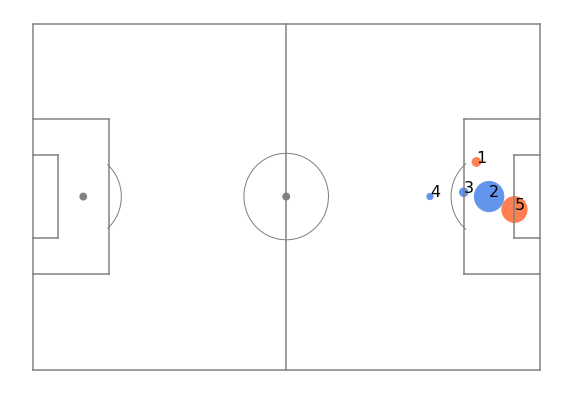

In [24]:
pitch_length, pitch_width = 120, 80
home_team, away_team = "France", "Croatia"
team_colors = {"Croatia": "coral", "France": "cornflowerblue"}

(fig, ax) = createPitch(pitch_length, pitch_width, "yards", "gray")

for idx, goal in goals.iterrows():
    x = goal["location"][0]
    y = goal["location"][1]
    team, player = goal["team_name"], goal["player_name"]
    
    circle_size = np.sqrt(goal["shot_statsbomb_xg"]) * 4
    goal_circle = plt.Circle((x, pitch_width - y), circle_size, color = team_colors[goal["team_name"]])
    goal_circle.set_alpha = 0.95
    plt.text(x, pitch_width - y, idx + 1, size = 16)
    ax.add_patch(goal_circle)
    print(f"{idx + 1} - {goal['player_name']}")

fig.set_size_inches(10, 7)

plt.show()

---

**Isolating Passes from Assists**

In [25]:
passes = df.loc[~(df["pass_shot_assist"].isnull()) |
                ~(df["pass_goal_assist"].isnull())].reset_index()
passes["pass_goal_assist"].replace({np.nan: False}, inplace = True)

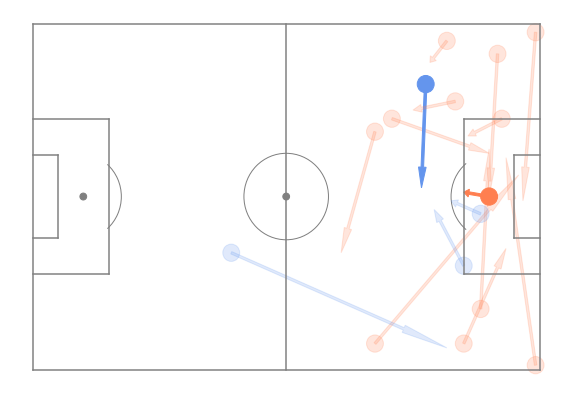

In [27]:
pitch_length, pitch_width = 120, 80
home_team, away_team = "France", "Croatia"
team_colors = {"Croatia": "coral", "France": "cornflowerblue"}

(fig, ax) = createPitch(pitch_length, pitch_width, "yards", "gray")

for idx, _pass in passes.iterrows():
    circle_alpha = 1 if _pass["pass_goal_assist"] else 0.2
    x, y = _pass["location"][0], _pass["location"][1]
    pass_circle = plt.Circle((x, pitch_width - y), 2, color = team_colors[_pass["team_name"]])
    pass_circle.set_alpha(circle_alpha)
    ax.add_patch(pass_circle)
    dx = _pass["pass_end_location"][0] - x
    dy = _pass["pass_end_location"][1] - y
    pass_arrow = plt.Arrow(x, pitch_width - y, dx, -dy, width = 3, color = team_colors[_pass["team_name"]])
    pass_arrow.set_alpha(circle_alpha)
    ax.add_patch(pass_arrow)
        
fig.set_size_inches(10, 7)
plt.show()

---

In [32]:
target_team = "France"

target_matches = list()
for match in matches:
    if (match["home_team"]["home_team_name"] == target_team) or (match["away_team"]["away_team_name"] == target_team):
        target_matches.append(match)

In [41]:
dfs = list()
    
def is_pass_in_range(pass_time, start_window, end_window):
    return (True in ((start_window < pass_time) & (pass_time < end_window)).unique())

for match in target_matches:
    with open(f"{STATSBOMB_EVENTS_PATH}/{match['match_id']}.json", "r", encoding = "utf-8") as f:
        data = json.load(f)
    df = pd.json_normalize(data, sep = "_").assign(match_id = match["match_id"])
    df = df[df["team_name"] == target_team]
    passes = df.loc[df.type_name == "Pass"]
    shots = df.loc[df.type_name == "Shot"]
    shots_time = shots["minute"] * 60 + shots["second"]
    shot_start = shots_time - 15
    pass_times = passes["minute"] * 60 + passes["second"]
    
    pass_to_shot = pass_times.apply(lambda x: is_pass_in_range(x, shot_start, shots_time))
    
    is_pass_corner = passes["pass_type_name"] == "Corner"
    
    field_passes = passes[np.logical_and(pass_to_shot, np.logical_not(is_pass_corner))]
    dfs.append(field_passes)
    print('Match: ' + str(match["match_id"]) + '. Number of danger passes is: ' + str(len(field_passes)))

Match: 7530. Number of danger passes is: 20
Match: 7546. Number of danger passes is: 29
Match: 7580. Number of danger passes is: 19
Match: 8649. Number of danger passes is: 26
Match: 8658. Number of danger passes is: 22
Match: 7563. Number of danger passes is: 48
Match: 8655. Number of danger passes is: 56


In [44]:
passes = pd.concat(dfs, ignore_index = True)

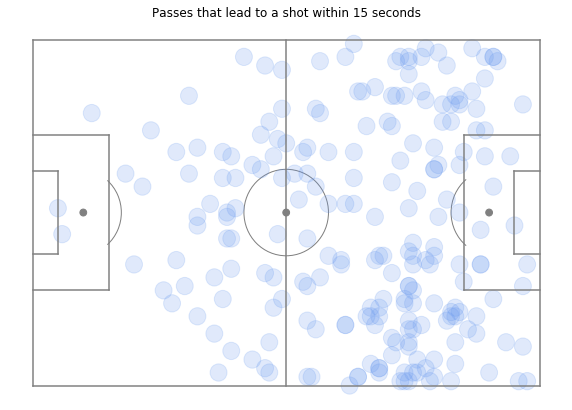

In [47]:
pitch_length, pitch_width = 120, 80

(fig, ax) = createPitch(pitch_length, pitch_width, "yards", "gray")

for idx, _pass in passes.iterrows():
    x = _pass["location"][0]
    y = pitch_width - _pass["location"][1]
    pass_circle = plt.Circle((x, y), 2, color = "cornflowerblue")
    pass_circle.set_alpha(0.2)
    ax.add_patch(pass_circle)

ax.set_title("Passes that lead to a shot within 15 seconds")
fig.set_size_inches(10, 7)
plt.show()

## Passes Heatmap

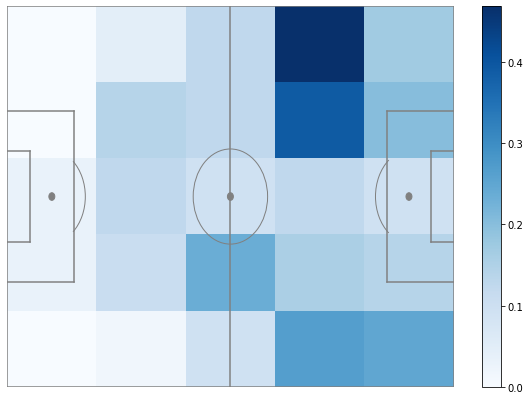

In [102]:
pitch_length, pitch_width = 120, 80

xs = list()
ys = list()

for idx, _pass in passes.iterrows():
    xs.append(_pass["location"][0])
    ys.append(pitch_width - _pass["location"][1])

histo_passes = np.histogram2d(ys, xs, bins = 5, range = [[0, pitch_width], [0, pitch_length]])

(fig, ax) = createPitch(pitch_length, pitch_width, "yards", "gray")

position = ax.imshow(histo_passes[0] / len(matches),
                     extent = [0, pitch_length, 0, pitch_width],
                     aspect = "auto", cmap = plt.cm.Blues)

fig.colorbar(position, ax = ax)
fig.set_size_inches(10, 7)
plt.show()

In [103]:
passes.player_name.value_counts()

Paul Pogba                                    28
Antoine Griezmann                             22
N"Golo Kanté                                  22
Kylian Mbappé Lottin                          19
Olivier Giroud                                17
Lucas Hernández Pi                            17
Benjamin Pavard                               16
Blaise Matuidi                                12
Raphaël Varane                                12
Ousmane Dembélé                               11
Djibril Sidibé                                 9
Samuel Yves Umtiti                             8
Corentin Tolisso                               7
Steven N"Kemboanza Mike Christopher Nzonzi     7
Thomas Lemar                                   5
Presnel Kimpembe                               2
Nabil Fekir                                    2
Benjamin Mendy                                 2
Hugo Lloris                                    2
Name: player_name, dtype: int64

---

In [110]:
pitch_length, pitch_width = 120, 80
shot_window = 15

In [111]:
def is_pass_in_range(pass_time, start_window, end_window):
    return (True in ((start_window < pass_time) & (pass_time < end_window)).unique())

In [113]:
comp_id, seas_id = 43, 3

with open(f"{STATSBOMB_MATCHES_PATH}/{comp_id}/{seas_id}.json", "r", encoding = "utf-8") as file:
    matches = json.load(file)

teams = list()
match_ids = list()

for match in matches:
    teams.append(match["home_team"]["home_team_name"])
    teams.append(match["away_team"]["away_team_name"])
    match_ids.append(match["match_id"])

teams = list(set(teams))
match_ids = list(set(match_ids))

pass_shot_df = pd.DataFrame(columns = ["Team", "Passes", "Shots", "Goals", "Matches", "Danger Passes"])
danger_passes_by_team = dict()
match_number_by_team = dict()

for match in matches:
    #print(f"{match['home_team']['home_team_name']} - {match['away_team']['away_team_name']}")
    with open(f"{STATSBOMB_EVENTS_PATH}/{match['match_id']}.json", "r", encoding = "utf-8") as f:
        data = json.load(f)
    df_match = pd.json_normalize(data, sep = "_").assign(match_id = match["match_id"])
    
    for team in (match["home_team"]["home_team_name"], match["away_team"]["away_team_name"]):
        df_team = df_match[df_match["team_name"] == team]
        team_passes = df_team.loc[df_team["type_name"] == "Pass"]
        team_shots = df_team.loc[df_team["type_name"] == "Shot"]
    
        shots_time = team_shots["minute"] * 60 + team_shots["second"]
        passes_time = team_passes["minute"] * 60 + team_passes["second"]
        
        shots_start = shots_time - shot_window
        pass_to_shot = passes_time.apply(lambda x: is_pass_in_range(x, shots_start, shots_time))
        is_pass_corner = team_passes["pass_type_name"] == "Corner"
        danger_passes = team_passes[np.logical_and(pass_to_shot, np.logical_not(is_pass_corner))]
        
        if team not in danger_passes_by_team:
            danger_passes_by_team[team] = danger_passes
            match_number_by_team[team] = 1
        else:
            danger_passes_by_team[team] = danger_passes_by_team[team].append(danger_passes)
            match_number_by_team[team] = match_number_by_team[team] + 1
        
        goals_scored = match["home_score"] if team == match["home_team"]["home_team_name"] else match["away_score"]
            
        pass_shot_df = pass_shot_df.append({
            "Team": team,
            "Passes": len(team_passes),
            "Shots": len(team_shots),
            "Goals": goals_scored,
            "Danger Passes": len(danger_passes)},ignore_index=True)

Croatia - Denmark
Nigeria - Iceland
Poland - Colombia
Croatia - Nigeria
Brazil - Costa Rica
Germany - Mexico
Australia - Peru
Serbia - Brazil
Senegal - Colombia
Panama - Tunisia
Switzerland - Costa Rica
France - Australia
Uruguay - Russia
Brazil - Mexico
Russia - Croatia
Denmark - Australia
Costa Rica - Serbia
France - Peru
Belgium - Japan
Belgium - Panama
Argentina - Croatia
France - Argentina
Brazil - Belgium
Uruguay - France
France - Croatia
Iceland - Croatia
Poland - Senegal
Denmark - France
Egypt - Uruguay
Argentina - Iceland
Spain - Russia
Belgium - Tunisia
Peru - Denmark
Uruguay - Saudi Arabia
South Korea - Mexico
Spain - Morocco
Brazil - Switzerland
Nigeria - Argentina
Japan - Senegal
Saudi Arabia - Egypt
Uruguay - Portugal
Japan - Poland
Morocco - Iran
Iran - Spain
Russia - Saudi Arabia
Sweden - South Korea
Portugal - Spain
Portugal - Morocco
Mexico - Sweden
Iran - Portugal
England - Panama
England - Belgium
Colombia - England
Sweden - Switzerland
Croatia - England
Sweden - En

In [114]:
pass_shot_df.head()

,Team,Passes,Shots,Goals,Matches,Danger Passes
0,Croatia,665,26,1,NaN,50
1,Denmark,581,19,1,NaN,40
2,Nigeria,529,17,2,NaN,40
3,Iceland,339,10,0,NaN,25
4,Poland,448,11,0,NaN,25


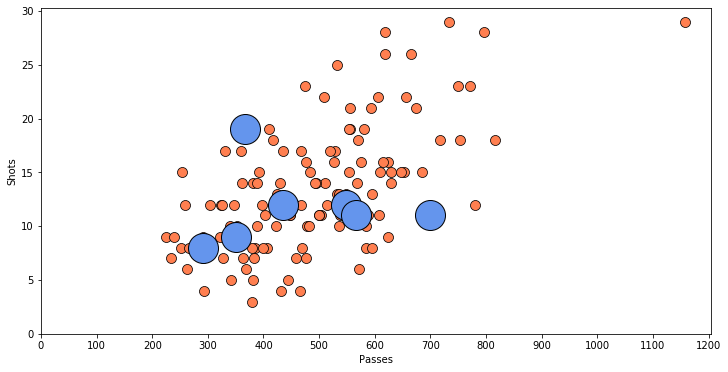

In [132]:
fig, ax = plt.subplots(figsize = (12, 6))

target_team = "France"

ax.plot("Passes", "Shots", data = pass_shot_df,
        linestyle = "None", markersize = 10, marker = "o", color = "coral",
        markeredgecolor = "k", markeredgewidth = 0.75)

target_matches = (pass_shot_df["Team"] == target_team)
ax.plot("Passes", "Shots", data = pass_shot_df[target_matches],
        linestyle = "None", markersize = 30, marker = "o", color = "cornflowerblue",
        markeredgecolor = "k")

ax.set_xticks(np.arange(0,1300, step = 100))
ax.set_yticks(np.arange(0, 35, step = 5))
ax.set_xlabel("Passes")
ax.set_ylabel("Shots")

plt.show()

In [134]:
pass_shot_df["Shots"] = pd.to_numeric(pass_shot_df["Shots"]) 
pass_shot_df["Passes"] = pd.to_numeric(pass_shot_df["Passes"]) 
pass_shot_df["Goals"] = pd.to_numeric(pass_shot_df["Goals"])

model = smf.ols(formula = "Shots ~ Passes", data = pass_shot_df[["Shots", "Passes"]]).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Shots   R-squared:                       0.357
Model:                            OLS   Adj. R-squared:                  0.352
Method:                 Least Squares   F-statistic:                     70.08
Date:                Sat, 26 Jun 2021   Prob (F-statistic):           9.30e-14
Time:                        12:11:49   Log-Likelihood:                -374.69
No. Observations:                 128   AIC:                             753.4
Df Residuals:                     126   BIC:                             759.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      2.0354      1.408      1.446      0.151      -0.751       4.821
Passes         0.0230      0.003      8.371      0.000       0.018       0.028
==============================================================================
Omnibus:                        3.252   Durbin-Watson:                   1.893
Prob(Omnibus):                  0.197   Jarque-Bera (JB):                3.253
Skew:                           0.380   Prob(JB):                        0.197
Kurtosis:                       2.818   Cond. No.                     1.79e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.79e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

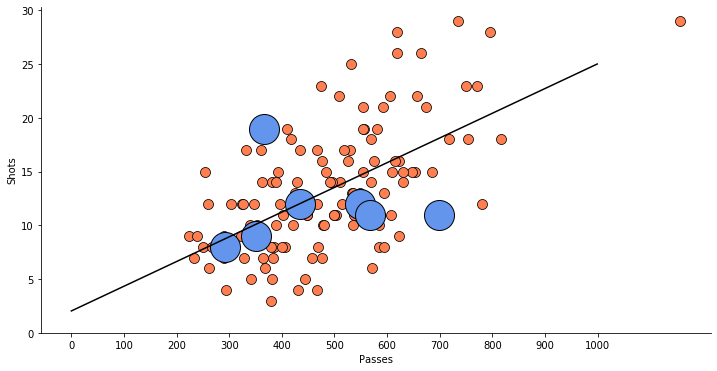

In [138]:
fig, ax = plt.subplots(figsize = (12, 6))

target_team = "France"

ax.plot("Passes", "Shots", data = pass_shot_df,
        linestyle = "None", markersize = 10, marker = "o", color = "coral",
        markeredgecolor = "k", markeredgewidth = 0.75)

target_matches = (pass_shot_df["Team"] == target_team)
ax.plot("Passes", "Shots", data = pass_shot_df[target_matches],
        linestyle = "None", markersize = 30, marker = "o", color = "cornflowerblue",
        markeredgecolor = "k")

x_axis = np.arange(0, 1000, step = 0.5)
ys = model.params[0] + model.params[1] * x_axis

ax.plot(x_axis, ys, linestyle = "-", color = "k")

ax.set_xticks(np.arange(0,1100, step = 100))
ax.set_yticks(np.arange(0, 35, step = 5))
ax.set_xlabel("Passes")
ax.set_ylabel("Shots")

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

plt.show()

In [139]:
# Still need to visualize this model
poisson_model = smf.glm(formula = "Goals ~ Passes + Team", data = pass_shot_df,
                        family = sm.families.Poisson()).fit()
poisson_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                  Goals   No. Observations:                  128
Model:                            GLM   Df Residuals:                       95
Model Family:                 Poisson   Df Model:                           32
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -170.23
Date:                Sat, 26 Jun 2021   Deviance:                       111.91
Time:                        12:15:14   Pearson chi2:                     93.5
No. Iterations:                     5                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept                1.2704      0.649      1.957      0.050      -0.002       2.543
Team[T.Australia]       -0.9423      0.820     -1.150      0.250      -2.549       0.664
Team[T.Belgium]          0.3177      0.482      0.659      0.510      -0.628       1.263
Team[T.Brazil]           0.0121      0.541      0.022      0.982      -1.048       1.073
Team[T.Colombia]        -0.1591      0.584     -0.272      0.785      -1.304       0.986
Team[T.Costa Rica]      -1.1427      0.839     -1.362      0.173      -2.787       0.502
Team[T.Croatia]          0.2357      0.489      0.482      0.630      -0.723       1.194
Team[T.Denmark]         -0.9243      0.720     -1.284      0.199      -2.335       0.487
Team[T.Egypt]           -1.0459      0.827     -1.264      0.206      -2.668       0.576
Team[T.England]          0.0960      0.500      0.192      0.848      -0.885       1.077
Team[T.France]           0.0679      0.506      0.134      0.893      -0.924       1.060
Team[T.Germany]         -0.6956      0.820     -0.849      0.396      -2.302       0.911
Team[T.Iceland]         -1.2544      0.856     -1.465      0.143      -2.932       0.424
Team[T.Iran]            -1.3115      0.866     -1.514      0.130      -3.010       0.387
Team[T.Japan]           -0.1050      0.580     -0.181      0.856      -1.242       1.032
Team[T.Mexico]          -0.9385      0.721     -1.301      0.193      -2.352       0.475
Team[T.Morocco]         -1.0921      0.834     -1.310      0.190      -2.726       0.542
Team[T.Nigeria]         -0.6720      0.724     -0.928      0.353      -2.091       0.747
Team[T.Panama]          -1.1746      0.843     -1.393      0.164      -2.827       0.478
Team[T.Peru]            -1.0077      0.824     -1.223      0.221      -2.623       0.608
Team[T.Poland]          -0.9520      0.820     -1.161      0.246      -2.560       0.656
Team[T.Portugal]        -0.1625      0.585     -0.277      0.781      -1.310       0.985
Team[T.Russia]           0.0792      0.537      0.147      0.883      -0.973       1.131
Team[T.Saudi Arabia]    -0.8094      0.817     -0.991      0.322      -2.410       0.791
Team[T.Senegal]         -0.4600      0.675     -0.682      0.495      -1.783       0.862
Team[T.Serbia]          -1.0928      0.832     -1.313      0.189      -2.724       0.539
Team[T.South Korea]     -0.7983      0.743     -1.075      0.283      -2.254       0.658
Team[T.Spain]            0.5124      0.593      0.864      0.387      -0.649       1.674
Team[T.Sweden]          -0.6212      0.623     -0.997      0.319      -1.842       0.600
Team[T.Switzerland]     -0.2601      0.607     -0.429      0.668      -1.450       0.930
Team[T.Tunisia]         -0.0691      0.614     -0.112      0.911      -1.273       1.135
Team[T.Uruguay]         -0.2932      0.573     -0.512    

---

In [141]:
len(teams)

32

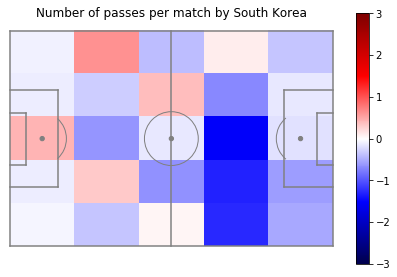

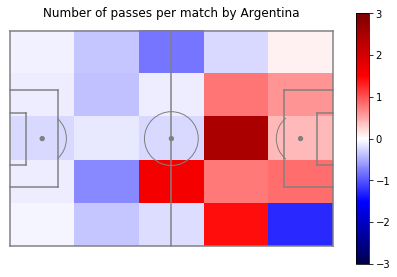

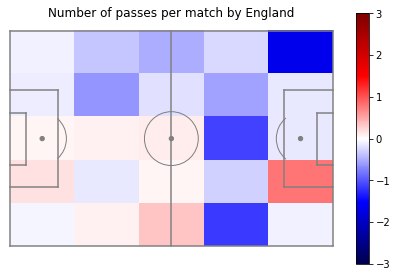

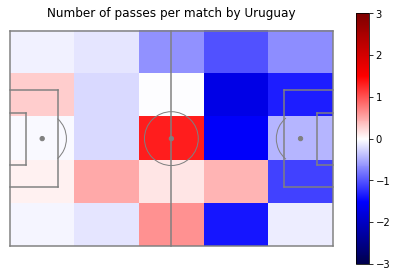

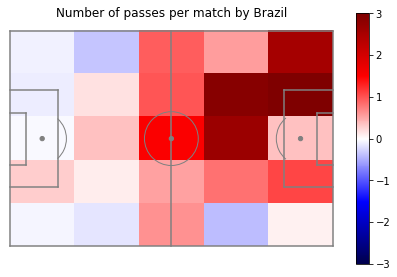

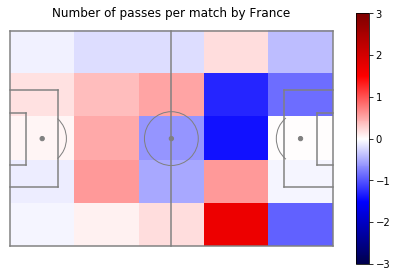

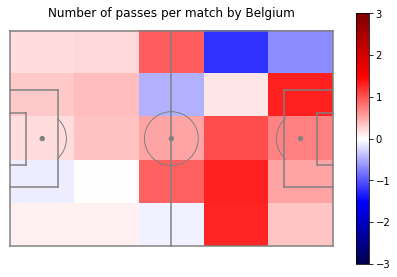

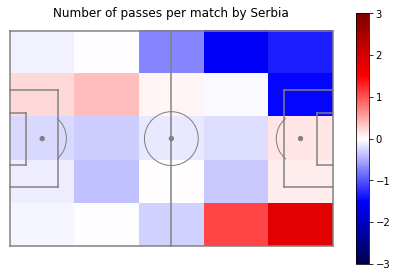

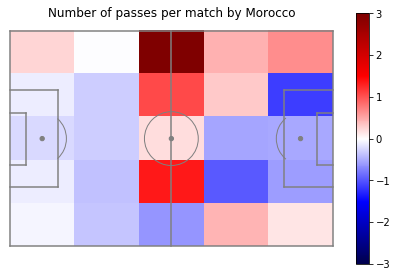

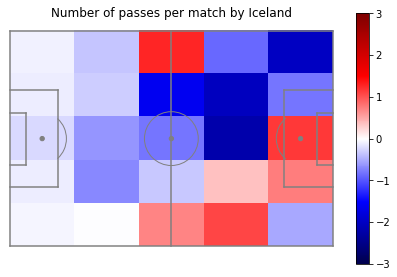

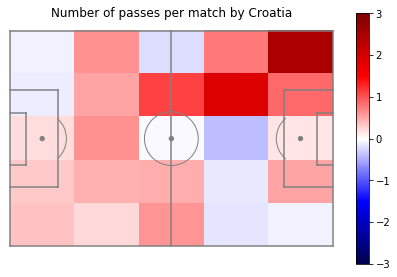

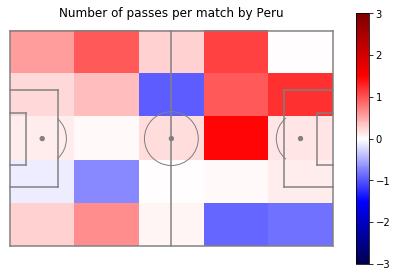

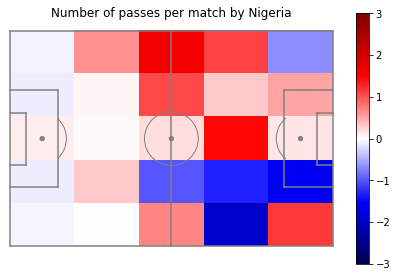

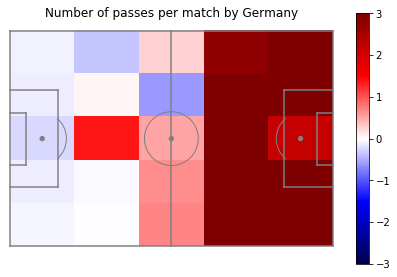

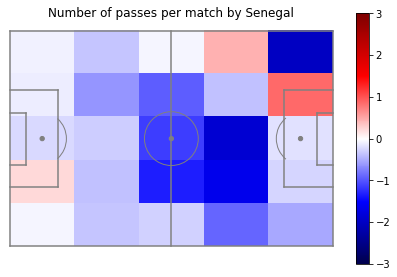

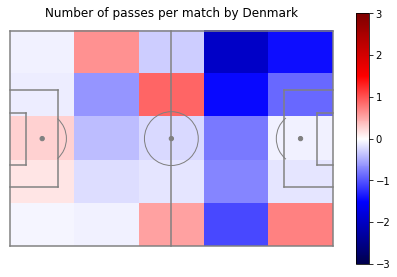

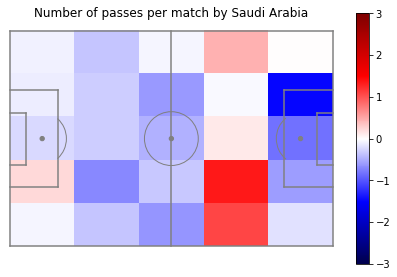

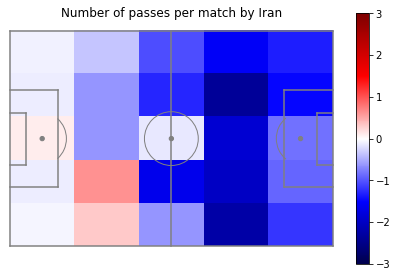

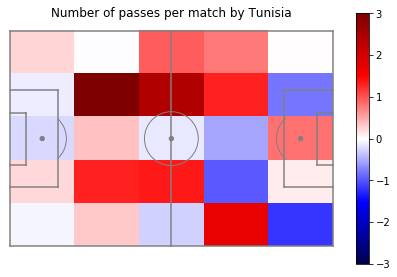

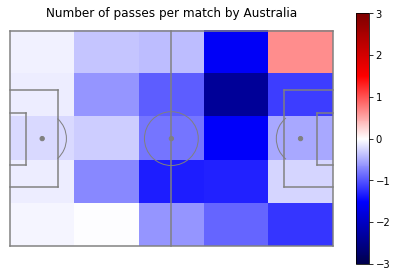

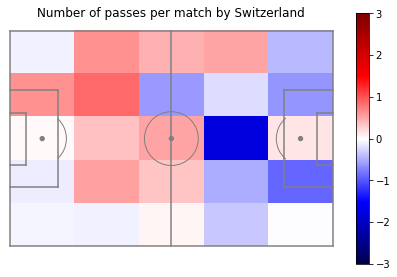

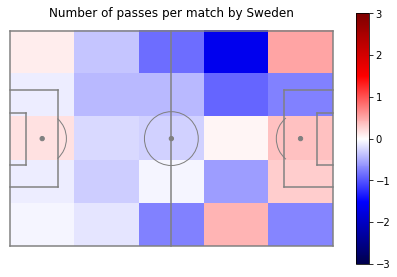

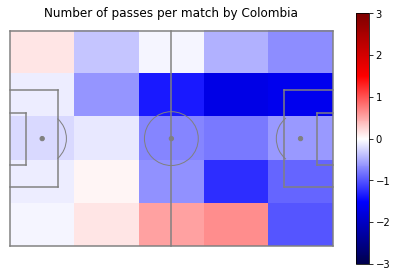

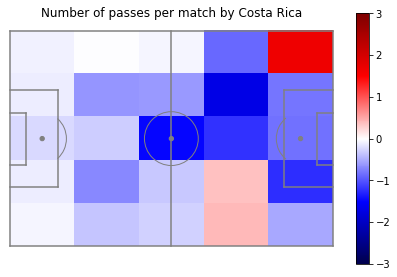

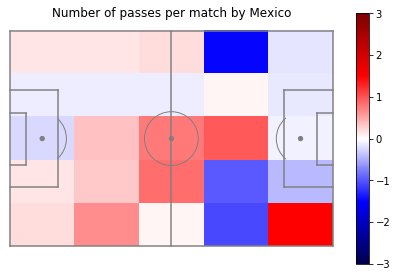

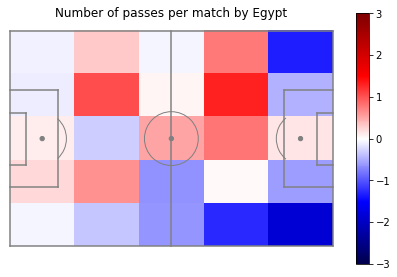

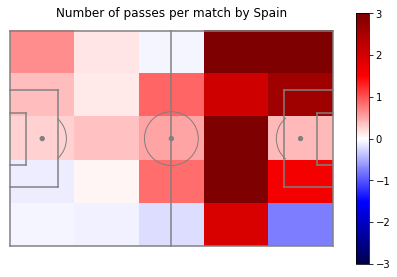

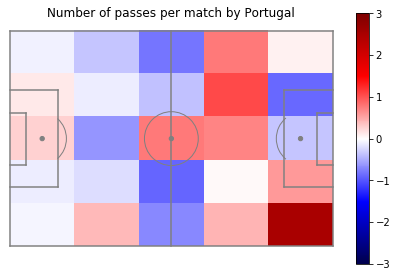

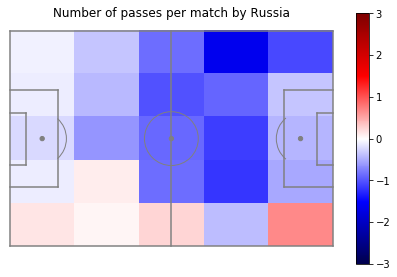

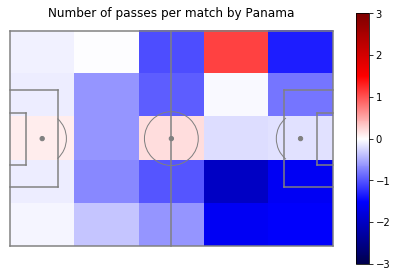

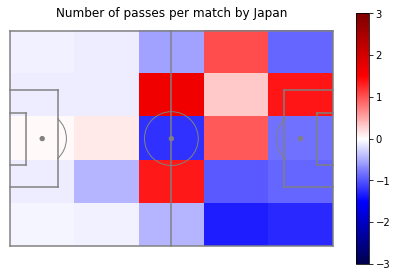

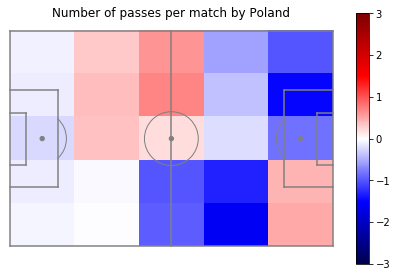

In [151]:
xs = list()
ys = list()

histo_pass = dict()

for team in teams:
    x = list()
    y = list()
    for idx, _pass in danger_passes_by_team[team].iterrows():
        x.append(_pass["location"][0])
        y.append(pitch_width - _pass["location"][1])
    
    histo_pass[team] = np.histogram2d(y, x, bins = 5, range = [[0, pitch_width], [0, pitch_length]])
    
    xs = xs + x
    ys = ys + y
    
full_histo_pass = np.histogram2d(ys, xs, bins = 5, range = [[0, pitch_width], [0, pitch_length]])

for team in teams:
    (fig, ax) = createPitch(pitch_length, pitch_width, "yards", "gray")
    position = ax.imshow(histo_pass[team][0] / match_number_by_team[team] - full_histo_pass[0]/(len(matches)*2),
                         extent = [0, 120, 0, 80], aspect = "auto", cmap = plt.cm.seismic,
                         vmin = -3, vmax = 3)
    
    ax.set_title(f"Number of passes per match by {team}")
    plt.xlim((-1,121))
    plt.ylim((83,-3))
    plt.tight_layout()
    plt.gca().set_aspect("equal", adjustable = "box")
    fig.colorbar(position, ax = ax)
    plt.show()

---

In [11]:
comp_id, seas_id = 43, 3

with open(f"{STATSBOMB_MATCHES_PATH}/{comp_id}/{seas_id}.json", "r", encoding = "utf-8") as file:
    matches = json.load(file)

all_events = list()
for match in matches:
    with open(f"{STATSBOMB_EVENTS_PATH}/{match['match_id']}.json", "r", encoding = "utf-8") as f:
        events = json.load(f)
    passes = [x for x in events if x["type"]["name"] == "Pass"]
    for a in passes:
        attributes = {
            "player_name": a['player']['name'],
            "outcome": 0 if 'outcome' in a['pass'].keys() else 1}
        all_events.append(attributes)

pass_df = pd.DataFrame(all_events)

In [12]:
len(pass_df)

62881

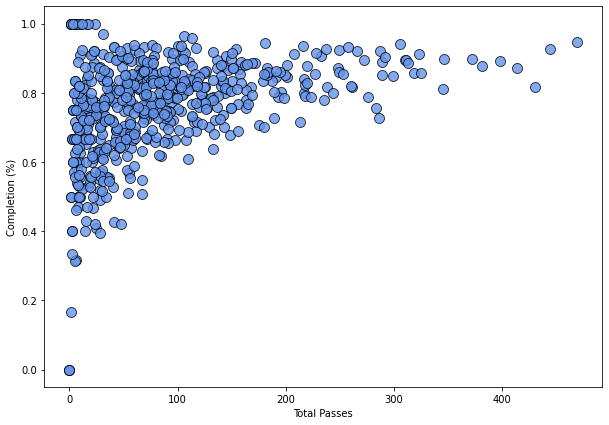

In [26]:
total_passes = pass_df.groupby('player_name')['outcome'].sum()
percentage = pass_df.groupby('player_name')['outcome'].mean()

fig, ax = plt.subplots(figsize = (10, 7))
plt.scatter(total_passes, percentage, color = "cornflowerblue",
            alpha = 0.8, s = 100, edgecolor = "k", linewidth = 0.9)
plt.xlabel("Total Passes")
plt.ylabel("Completion (%)")
plt.show()

In [39]:
model = LinearRegression()
#model.fit([[x] for x in total_passes], percentage)
model.fit(total_passes.values.reshape((total_passes.shape[0], 1)),
          percentage.values.reshape((percentage.shape[0], 1)))
model.intercept_, model.coef_

(array([0.70941856]), array([[0.00063207]]))

In [45]:
x_axis = np.arange(0, 501)
y_pred = model.predict(x_axis.reshape((len(x_axis), 1)))

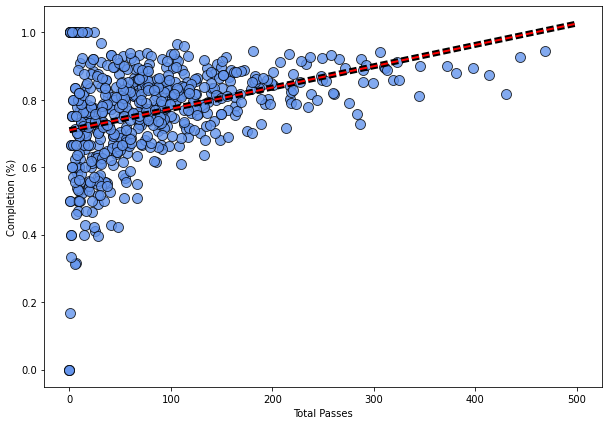

In [55]:
fig, ax = plt.subplots(figsize = (10, 7))

line_edge = [plt_eff.Stroke(linewidth = 6, foreground= "k"), plt_eff.Normal()]

plt.scatter(total_passes, percentage, color = "cornflowerblue",
            alpha = 0.8, s = 100, edgecolor = "k", linewidth = 0.9)

plt.plot(x_axis, y_pred, "r", linewidth = 2,
         linestyle = "dashed", path_effects = line_edge)

plt.xlabel("Total Passes")
plt.ylabel("Completion (%)")
plt.show()

---

In [62]:
comp_id, seas_id = 43, 3

with open(f"{STATSBOMB_MATCHES_PATH}/{comp_id}/{seas_id}.json", "r", encoding = "utf-8") as file:
    matches = json.load(file)

all_events = list()
for match in matches:
    with open(f"{STATSBOMB_EVENTS_PATH}/{match['match_id']}.json", "r", encoding = "utf-8") as f:
        events = json.load(f)
    shots = [x for x in events if x['type']['name'] == "Shot"]
    for s in shots:
        attributes = {
            "x": s['location'][0],
            "y": s['location'][1],
            "head": 1 if s['shot']['body_part']['name'] == "Head" else 0,
            "phase": s['shot']['type']['name'],
            "outcome": 1 if s['shot']['outcome']['name'] == "Goal" else 0,
            "statsbomb_xg": s['shot']['statsbomb_xg']}
        all_events.append(attributes)
            
shots_df = pd.DataFrame(all_events)

In [63]:
def distance_to_goal(origin):
    dest = np.array([120., 40.])
    return np.sqrt(np.sum((origin - dest) ** 2))
                   
def goal_angle(origin):
    p0 = np.array((120., 36.))  # Left Post
    p1 = np.array(origin, dtype=np.float)
    p2 = np.array((120., 44.))  # Right Post

    v0 = p0 - p1
    v1 = p2 - p1
    
    angle = np.abs(np.math.atan2(np.linalg.det([v0, v1]), np.dot(v0, v1)))
    
    return angle

In [64]:
shots_df['distance_to_goal'] = shots_df.apply(lambda row: distance_to_goal(row[['x', 'y']]), axis = 1)
shots_df['goal_angle'] = shots_df.apply(lambda r: goal_angle(r[['x', 'y']]), axis = 1)

In [65]:
shots = shots_df[~shots_df['phase'].isin(['Free Kick', 'Penalty'])]

In [66]:
features = shots[['distance_to_goal', 'goal_angle', 'head']]
labels = shots['outcome']

model = LogisticRegression()
model.fit(features, labels)

LogisticRegression()

In [69]:
model.intercept_

array([-1.2460818])

In [67]:
model.coef_

array([[-0.09984894,  1.10204566, -0.83732971]])

In [70]:
model.predict_proba(features)

array([[0.77296576, 0.22703424],
       [0.78136064, 0.21863936],
       [0.9644206 , 0.0355794 ],
       ...,
       [0.96992381, 0.03007619],
       [0.97437519, 0.02562481],
       [0.80660728, 0.19339272]])

In [71]:
y_pred = model.predict_proba(features)[:, 1]

In [74]:
df_check = shots.copy()
df_check["model_xg"] = y_pred
df_check["xg_diff"] = df_check["statsbomb_xg"] - df_check["model_xg"]
df_check.head(1)

,x,y,head,phase,outcome,statsbomb_xg,distance_to_goal,goal_angle,model_xg,xg_diff
0,115.0,34.0,0,Open Play,1,0.074087,7.81025,0.726642,0.227034,-0.152947


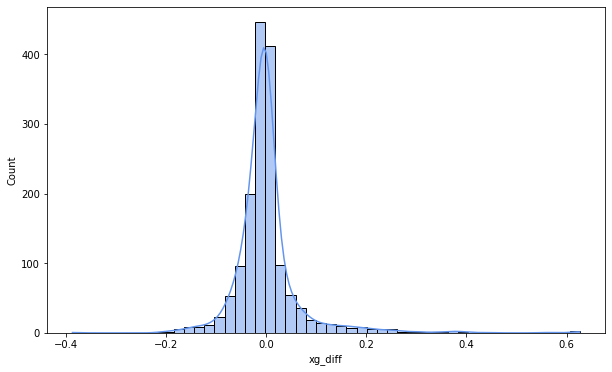

In [79]:
fig, ax = plt.subplots(figsize = (10, 6))

sns.histplot(data = df_check, x = "xg_diff",
             kde = True, bins = 50,
             color = "cornflowerblue")

plt.show()

In [86]:
threshold = 0.1

df_check["within_margin"] = df_check["xg_diff"].apply(lambda x: 1 if np.abs(x) <= threshold else 0)

In [89]:
np.sum(df_check.within_margin) / len(df_check)

0.9170951156812339

---

In [29]:
class Pitch(object):
    def __init__(self, xmax_data, ymax_data, length = 120, width = 80, padding = 5):
        self.length = length
        self.width = width
        
        self.xmax_data = xmax_data
        self.ymax_data = ymax_data
        
        self.xlimit = (-padding, self.length + padding)
        self.ylimit = (-padding, self.width + padding)
        
        self.penalty_area_length = 18
        self.penalty_area_width = 44
        self.small_area_length = 6
        self.small_area_width = 20
        self.penalty_kick_length = 12
        self.center_radius = 10
        self.goal_width = 8

    def get_components(self):
        rect, circ = plt_patches.Rectangle, plt_patches.Circle
        
        components = {
            "border": (rect, {"xy": (0, 0), "width": self.length, "height": self.width}),
            "left_circle": (circ, {"xy": (self.penalty_kick_length, self.width/2),
                                   "radius": self.center_radius}),
            "right_circle": (circ, {"xy": (self.length - self.penalty_kick_length, self.width/2),
                                    "radius": self.center_radius}),
            "left_penalty": (rect, {"xy": (0, (self.width/2) - (self.penalty_area_width/2)),
                                    "width": self.penalty_area_length,"height": self.penalty_area_width}),
            "right_penalty": (rect, {"xy": (self.length, (self.width/2)-(self.penalty_area_width/2)),
                                    "width": -self.penalty_area_length,"height": self.penalty_area_width}),
            "left_pk_dot": (circ, {"xy": (self.penalty_kick_length, self.width/2),
                                   "radius": 0.2, "facecolor": (0, 0, 0, 1)}),
            "right_pk_dot": (circ, {"xy": (self.length - self.penalty_kick_length, self.width/2),
                                   "radius": 0.2, "facecolor": (0, 0, 0, 1)}),
            "left_small_area": (rect, {"xy": (0, (self.width/2)-(self.small_area_width/2)),
                        "width": self.small_area_length, "height": self.small_area_width}),
            "right_small_area": (rect, {"xy": (self.length, (self.width/2)-(self.small_area_width/2)),
                        "width": -self.small_area_length, "height": self.small_area_width}),
            "half_circle": (circ, {"xy": (self.length/2, self.width/2), "radius": self.center_radius}),
            "half_line": (rect, {"xy": (self.length/2, 0), "width": 0, "height": self.width}),
            "half_dot": (circ, {"xy": (self.length/2, self.width/2), "radius": 0.2, "facecolor": (0, 0, 0, 1)}),
            "post_left_top": (circ, {"xy": (0, self.width/2 + self.goal_width/2), "radius": 0.2}),
            "post_left_bot": (circ, {"xy": (0, self.width/2 - self.goal_width/2), "radius": 0.2}),
            "post_right_top": (circ, {"xy": (self.length, self.width/2 + self.goal_width/2), "radius": 0.2}),
            "post_right_bot": (circ, {"xy": (self.length, self.width/2 - self.goal_width/2), "radius": 0.2}),    
        }
        
        patches = list()
        pitch_constants = {"linewidth": 1, "facecolor": (1, 1, 1, 1), "edgecolor": (0, 0, 0, 1)}
        
        for __, (shape, params) in components.items():
            shape_attributes = pitch_constants.copy()
            for param, value in params.items():
                shape_attributes[param] = value
            patches.append(shape(**shape_attributes))
        
        return patches
    
    def get_adjusted_x(self, x):
        return x * (self.length / self.xmax_data)

    def get_adjusted_y(self, y):
        return y * (self.width / self.ymax_data)
        
    def draw_lines(self, ax, lines, graph_params = None):
        params = {"length_includes_head": True, "head_width": 2, "head_length": 2,
                  "width": 0.5, "facecolor": (0, 0, 0, 0.5), "edgecolor": (0, 0, 0, 0)}
        
        if graph_params is not None:
            params.update(graph_params)
                
        for start_x, start_y, end_x, end_y in lines:
            dx = end_x - start_x
            dy = end_y - start_y

            attributes = {"x": self.get_adjusted_x(start_x), "y": self.get_adjusted_y(start_y),
                          "dx": self.get_adjusted_x(dx), "dy": self.get_adjusted_y(dy)}
            ax.add_patch(plt_patches.FancyArrow(**attributes, **params))

    def draw_players(self, ax, points, labels, fontsize = 7):
        for i, label in enumerate(labels):
            x, y = points[i]
            ax.text(self.get_adjusted_x(x), self.get_adjusted_y(y), label,
                    fontsize = fontsize, ha = "center", va = "center")

    def draw_points(self, ax, points, graph_params = None, numbers = None):
        params = {"linewidth": 1, "facecolor": "cornflowerblue",
                  "edgecolor": "k", "linewidth": 2, "radius": 2}
        
        if graph_params is not None:
            params.update(graph_params)
            
        for x, y in points:
            attributes = {"xy": (self.get_adjusted_x(x), self.get_adjusted_y(y))}
            ax.add_patch(plt_patches.Circle(**attributes, **params))
        
        if numbers is not None:
            for i, number in enumerate(numbers):
                x, y = points[i]
                ax.text(self.get_adjusted_x(x), self.get_adjusted_y(y), number,
                        fontsize = 14, fontweight = "bold", color = "w", ha = "center", va = "center")
            
    def draw(self, ax):
        for patch in self.get_components():
            ax.add_patch(patch)

---

In [13]:
match_id = 8658

with open(f"{STATSBOMB_EVENTS_PATH}/{match_id}.json", "r", encoding = "utf-8") as file:
    events = json.load(file)

In [23]:
target_team = "France"

team_events = [event for event in events if event["team"]["name"] == target_team]

In [31]:
lineup = [ev for ev in team_events if ev["type"]["name"] == "Starting XI"][0]

starters = {p["player"]["id"]: {"name": p["player"]["name"],
                                "jersey": p["jersey_number"]} for p in lineup["tactics"]["lineup"]}
starters

{3099: {'name': 'Hugo Lloris', 'jersey': 1},
 5476: {'name': 'Benjamin Pavard', 'jersey': 2},
 5485: {'name': 'Raphaël Varane', 'jersey': 4},
 5492: {'name': 'Samuel Yves Umtiti', 'jersey': 5},
 5484: {'name': 'Lucas Hernández Pi', 'jersey': 21},
 20004: {'name': 'Paul Pogba', 'jersey': 6},
 3961: {'name': 'N"Golo Kanté', 'jersey': 13},
 3009: {'name': 'Kylian Mbappé Lottin', 'jersey': 10},
 4375: {'name': 'Blaise Matuidi', 'jersey': 14},
 5487: {'name': 'Antoine Griezmann', 'jersey': 7},
 3604: {'name': 'Olivier Giroud', 'jersey': 9}}

In [32]:
passes = [event for event in team_events if event["type"]["name"] == "Pass"]

In [33]:
pass_matrix = dict()

for p in passes:
    if "outcome" not in p["pass"].keys():
        passer_id = p["player"]["id"]
        recipient_id = p["pass"]["recipient"]["id"]
        
        a, b = sorted([passer_id, recipient_id])
        
        if a not in pass_matrix.keys():
            pass_matrix[a] = dict()
            
        if b not in pass_matrix[a].keys():
            pass_matrix[a][b] = 0
            
        pass_matrix[a][b] += 1 

In [58]:
positions = dict()

for e in team_events:
    
    if "player" in e.keys():
        player_id = e["player"]["id"]
        if player_id not in positions.keys():
            positions[player_id] = {"x": list(), "y": list()}
            
        if "location" in e.keys():
            positions[player_id]["x"].append(e["location"][0])
            positions[player_id]["y"].append(80 - e["location"][1])
            positions[player_id]
            
avg_positions = {k: [np.mean(v["x"]), np.mean(v["y"])] 
                 for k, v in positions.items() 
                 if k in starters.keys()}

In [59]:
lines = list()
weights = list()

for k, v in pass_matrix.items():
    if k in starters.keys():
        origin = avg_positions[k]
        for k_, v_ in pass_matrix[k].items():
            if k_ in starters.keys():
                dest = avg_positions[k_]
                lines.append([*origin, *dest])
                weights.append(v_)

In [65]:
avg_positions

{3604: [73.73267326732673, 40.68316831683168],
 4375: [54.285714285714285, 65.24489795918367],
 5485: [39.869565217391305, 23.0],
 20004: [53.39041095890411, 32.73287671232877],
 5476: [43.2375, 9.925],
 3961: [37.52173913043478, 54.94202898550725],
 5487: [69.25, 45.020833333333336],
 3009: [72.35051546391753, 14.927835051546392],
 3099: [9.052631578947368, 41.6578947368421],
 5492: [35.77333333333333, 54.093333333333334],
 5484: [47.946236559139784, 70.24731182795699]}

In [68]:
sorted(avg_positions)

[3009, 3099, 3604, 3961, 4375, 5476, 5484, 5485, 5487, 5492, 20004]

In [83]:
number_names = {el["player"]["id"]: {"name": el["player"]["name"], "num": el["jersey_number"]}
 for el in lineup["tactics"]["lineup"]}

number_names = {k: number_names[k] for k in sorted(number_names)}
number_names

{3009: {'name': 'Kylian Mbappé Lottin', 'num': 10},
 3099: {'name': 'Hugo Lloris', 'num': 1},
 3604: {'name': 'Olivier Giroud', 'num': 9},
 3961: {'name': 'N"Golo Kanté', 'num': 13},
 4375: {'name': 'Blaise Matuidi', 'num': 14},
 5476: {'name': 'Benjamin Pavard', 'num': 2},
 5484: {'name': 'Lucas Hernández Pi', 'num': 21},
 5485: {'name': 'Raphaël Varane', 'num': 4},
 5487: {'name': 'Antoine Griezmann', 'num': 7},
 5492: {'name': 'Samuel Yves Umtiti', 'num': 5},
 20004: {'name': 'Paul Pogba', 'num': 6}}

In [85]:
avg_positions = {k: avg_positions[k] for k in sorted(avg_positions)}
avg_positions

{3009: [72.35051546391753, 14.927835051546392],
 3099: [9.052631578947368, 41.6578947368421],
 3604: [73.73267326732673, 40.68316831683168],
 3961: [37.52173913043478, 54.94202898550725],
 4375: [54.285714285714285, 65.24489795918367],
 5476: [43.2375, 9.925],
 5484: [47.946236559139784, 70.24731182795699],
 5485: [39.869565217391305, 23.0],
 5487: [69.25, 45.020833333333336],
 5492: [35.77333333333333, 54.093333333333334],
 20004: [53.39041095890411, 32.73287671232877]}

In [106]:
#adjust_fill = lambda x: 0.8 / (1 + np.exp(-(x-20)*0.2))
#adjust_weight = lambda x: 2 / (1 + np.exp(-(x-10)*0.2))

adjust_fill = lambda x: 1 / (1 + np.exp(-(x-30)))
adjust_weight = lambda x: 1 / (1 + np.exp(-x))

In [ ]:

    if weights[i] > 5:
        graph_params = {"width": adjust_weight(weights[i]), "facecolor": (0, 0, 1, adjust_fill(weights[i]))}
        pitch.draw_lines(ax, [line], graph_params = graph_params)

10 - Kylian Mbappé Lottin
1 - Hugo Lloris
9 - Olivier Giroud
13 - N"Golo Kanté
14 - Blaise Matuidi
2 - Benjamin Pavard
21 - Lucas Hernández Pi
4 - Raphaël Varane
7 - Antoine Griezmann
5 - Samuel Yves Umtiti
6 - Paul Pogba


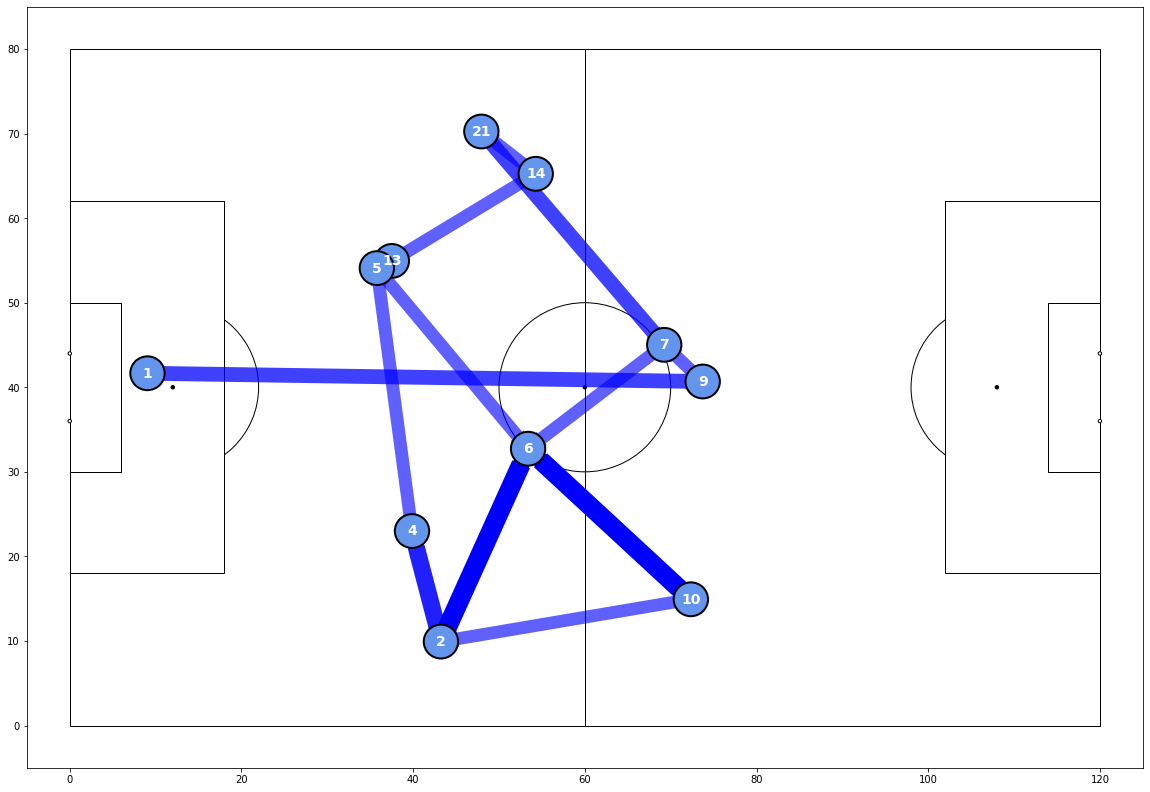

In [118]:
fig, ax = plt.subplots(figsize=(20, 14))

pitch = Pitch(xmax_data = 120, ymax_data = 80)
pitch.draw(ax)

adjusted_weights = (weights - np.min(weights))/(np.max(weights) - min(weights))

for i, line in enumerate(lines):
    if adjusted_weights[i] > 0.5:
        graph_params = {"width": weights[i] / 4, "facecolor": (0, 0, 1, adjusted_weights[i])}
        pitch.draw_lines(ax, [line], graph_params = graph_params)


pitch.draw_points(ax, [xy for k, xy in avg_positions.items()], numbers = [v["num"] for k, v in number_names.items()])

for k, v in number_names.items():
    print(f"{v['num']} - {v['name']}")

plt.ylim(pitch.ylimit)
plt.xlim(pitch.xlimit)
#plt.axis("off")
plt.show()

---

In [35]:
match_id = 8658

with open(f"{STATSBOMB_EVENTS_PATH}/{match_id}.json", "r", encoding = "utf-8") as file:
    events = json.load(file)

In [36]:
target_team = "France"

team_events = [event for event in events if event["team"]["name"] == target_team]

df = pd.json_normalize(team_events, sep = "_")

passes = df[df.type_name == "Pass"]
shots = df[df.type_name == "Shot"]

In [37]:
shots_time = shots["minute"] * 60 + shots["second"]
pass_time_threshold = shots_time - 15
passes_time = passes["minute"] * 60 + passes["second"]

In [41]:
def is_pass_in_range(pass_time, start_window, end_window):
    return (True in ((start_window < pass_time) & (pass_time < end_window)).unique())

pass_to_shot = passes_time.apply(lambda x: is_pass_in_range(x, pass_time_threshold, shots_time))

is_pass_corner = passes["pass_type_name"] == "Corner"

field_passes = passes[np.logical_and(pass_to_shot, np.logical_not(is_pass_corner))]

In [43]:
field_passes = field_passes[["location"]]
field_passes["x"] = field_passes["location"].apply(lambda x: x[0])
field_passes["y"] = field_passes["location"].apply(lambda x: x[1])
del field_passes["location"]
field_passes.head()

,x,y
499,7.0,45.0
504,42.0,38.0
509,52.0,29.0
512,48.0,32.0
576,44.0,77.0


In [44]:
hull = ConvexHull(field_passes)

In [49]:
for i in hull.simplices:
    print(i)

[16 11]
[4 0]
[19  0]
[21 11]
[21  4]
[14 16]
[14 19]


In [60]:
for i in hull.vertices:
    print(i)

16
11
21
4
0
19
14


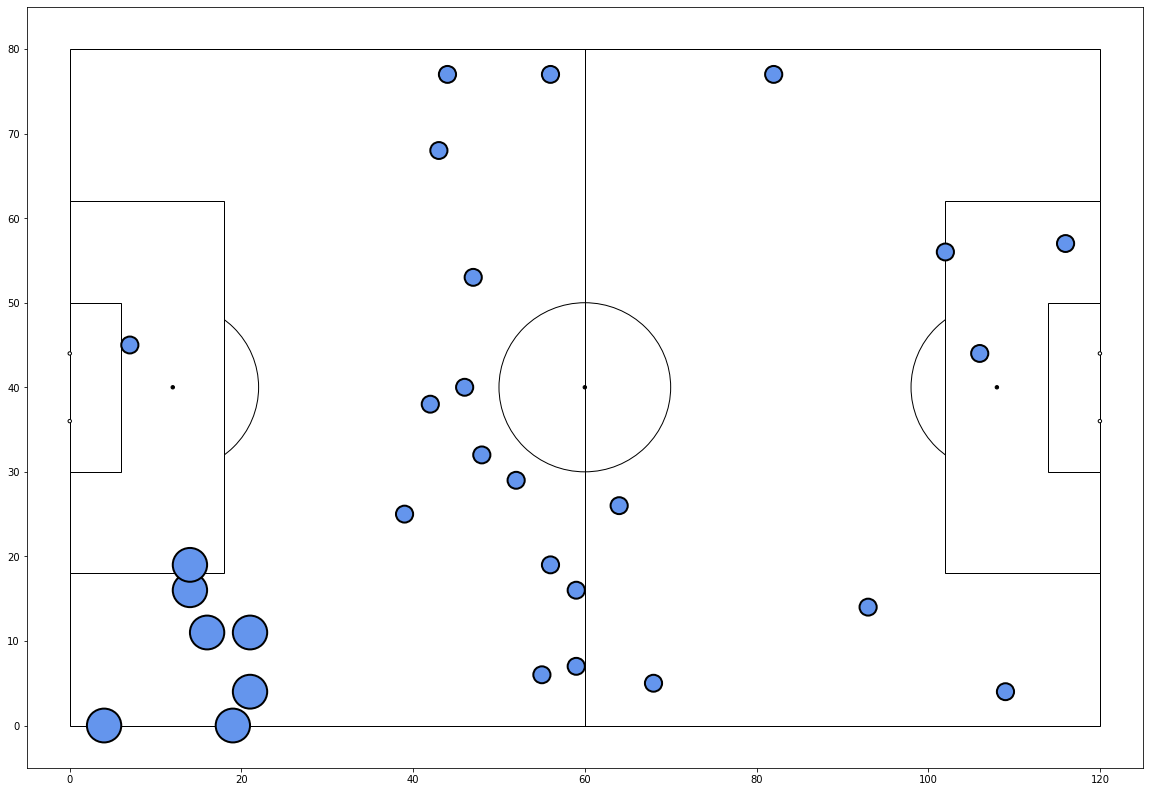

In [51]:
fig, ax = plt.subplots(figsize=(20, 14))

pitch = Pitch(xmax_data = 120, ymax_data = 80)
pitch.draw(ax)

pitch.draw_points(ax = ax,
                  points = [[el.x, el.y] for __, el in field_passes.iterrows()],
                  graph_params = {"radius": 1})

simplices = [el for el in hull.simplices]

pitch.draw_points(ax = ax,
                  points = simplices,
                  graph_params = {"radius": 2})


plt.xlim(pitch.xlimit)
plt.ylim(pitch.ylimit)
plt.show()